In [1]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    run_on_colab = True
else:
    print('Not running on CoLab')
    run_on_colab = False
if run_on_colab:
    from google.colab import drive
    drive.mount('/drive', force_remount=True)

Running on CoLab
Mounted at /drive


In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 126 µs (started: 2021-06-10 13:18:18 +00:00)


In [3]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

time: 2.4 s (started: 2021-06-10 13:18:18 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
import tensorflow as tf
print("Using Keras",tf.keras.__version__)

Using Keras 2.5.0
time: 2.52 ms (started: 2021-06-10 13:18:21 +00:00)


In [5]:
window_length = 10
timeframe = "15minutes"
classes = 2
candles = 1
network = None
scaler = None

time: 2.37 ms (started: 2021-06-10 13:18:21 +00:00)


In [6]:
train_df = pd.read_csv("/drive/My Drive/disertation/train_df_{}_{}_candles_{}_class.csv".format(timeframe, candles, classes))
train_df = train_df.set_index("open_time")

time: 1.75 s (started: 2021-06-10 13:18:21 +00:00)


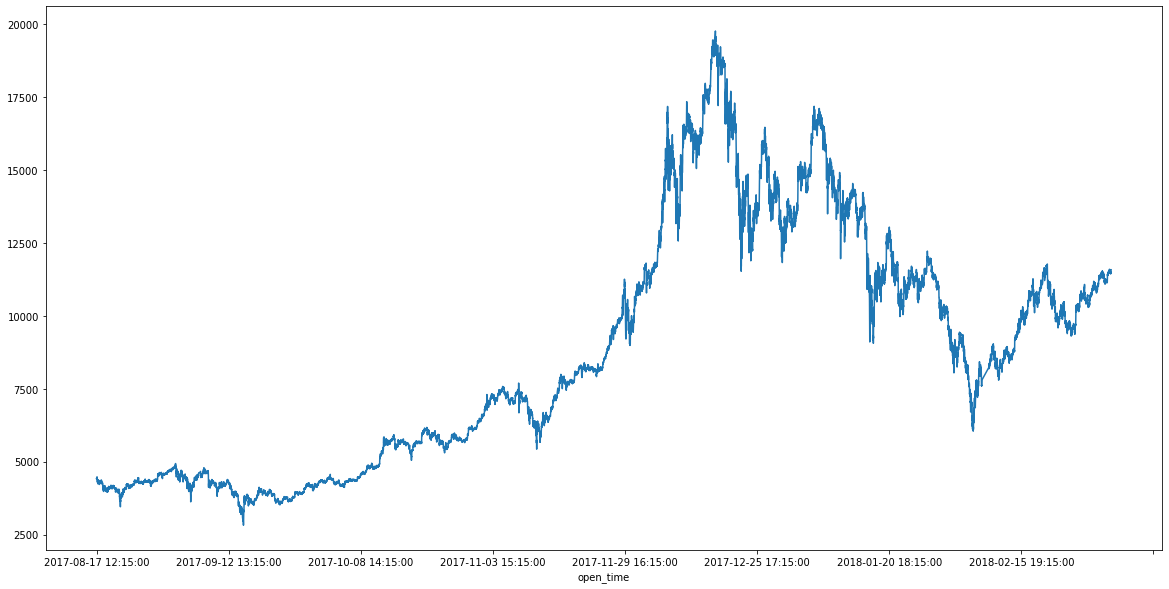

time: 299 ms (started: 2021-06-10 13:18:22 +00:00)


In [7]:
train_df["close"].plot()

In [8]:
train_df.drop(columns=["close"],inplace=True)
train_df.index = pd.to_datetime(train_df.index)

time: 17.2 ms (started: 2021-06-10 13:18:23 +00:00)


In [55]:
data = train_df.to_numpy()
X = data[:,:-1]
Y = data[:,-1]

X.shape, Y.shape

((19200, 27), (19200,))

time: 9.75 ms (started: 2021-06-10 14:10:43 +00:00)


In [56]:
n_features = X.shape[1]
n_features

27

time: 6.23 ms (started: 2021-06-10 14:10:44 +00:00)


In [57]:
def extend_dataset_with_window_length(X, Y, window_length=window_length):
    new_x = []
    for i in range(len(X) - window_length+1):
        lst = []
        for j in range(i, i+window_length):
            lst.extend(X[j])
        new_x.append(lst)
    return np.array(new_x), Y[window_length-1:]

time: 4.31 ms (started: 2021-06-10 14:10:44 +00:00)


In [58]:
X, Y = extend_dataset_with_window_length(X,Y)
X.shape, Y.shape

((19191, 270), (19191,))

time: 1.42 s (started: 2021-06-10 14:10:44 +00:00)


In [59]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

time: 46.9 ms (started: 2021-06-10 14:10:46 +00:00)


In [60]:
scaler_path = "/drive/My Drive/disertation/lstm_scaler_network_model_{}_{}.save".format(timeframe, window_length)
if scaler:
    joblib.dump(scaler, scaler_path)
else:
    scaler = joblib.load(scaler_path)

time: 9.2 ms (started: 2021-06-10 14:10:46 +00:00)


In [61]:
def get_subsample_same_distribution(X,Y, p=0.1):
    ys = pd.Series(Y)
    vs = ys.value_counts()
    original_indexes = []
    for idx in vs.index:
        required = int(p * vs[idx])
        print(required)
        original_indexes.extend(ys[ys==idx].sample(n=required, replace=False).index)
    return X[original_indexes], Y[original_indexes]

time: 5.68 ms (started: 2021-06-10 14:10:46 +00:00)


In [62]:
a,b = np.unique(Y, return_counts=True)
print("buy hold sell %")
print(b)
print(b / sum(b))

buy hold sell %
[10102  9089]
[0.52639258 0.47360742]
time: 4.21 ms (started: 2021-06-10 14:10:46 +00:00)


In [63]:
def get_equal_class_distribution(X,Y):
    ys = pd.Series(Y)
    vs = ys.value_counts()
    required_of_each_class = vs.min()
    original_indexes = []
    for idx in vs.index:
        original_indexes.extend(ys[ys==idx].sample(n=required_of_each_class, replace=False).index)
    return X[original_indexes], Y[original_indexes]

time: 6.9 ms (started: 2021-06-10 14:10:46 +00:00)


In [64]:
X,Y = get_equal_class_distribution(X,Y)
# X, Y = get_subsample_same_distribution(X,Y)

a,b = np.unique(Y, return_counts=True)
print("buy hold sell %")
print(b)
print(b / sum(b))

buy hold sell %
[9089 9089]
[0.5 0.5]
time: 41.7 ms (started: 2021-06-10 14:10:47 +00:00)


In [65]:
n_timesteps = window_length
X = X.reshape(X.shape[0], n_timesteps, n_features)
X.shape

(18178, 10, 27)

time: 9.71 ms (started: 2021-06-10 14:10:51 +00:00)


In [66]:
from tensorflow.keras import models
from tensorflow.keras import layers

network = models.Sequential()
network.add(layers.LSTM(100, input_shape=(n_timesteps,n_features)))
network.add(layers.Dropout(0.3))
network.add(layers.Dense(100, activation='relu'))

if classes == 2:
    network.add(layers.Dense(1, activation="sigmoid"))
else:
    network.add(layers.Dense(classes, activation="softmax"))

network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               51200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 61,401
Trainable params: 61,401
Non-trainable params: 0
_________________________________________________________________
time: 248 ms (started: 2021-06-10 14:11:08 +00:00)


In [67]:
if classes == 2:
    loss = "binary_crossentropy"
else:
    loss = 'categorical_crossentropy'
opt = tf.keras.optimizers.Adam( learning_rate=0.00005)
network.compile(optimizer='adam', loss=loss, metrics=['accuracy', tf.keras.metrics.AUC()],)

time: 14.9 ms (started: 2021-06-10 14:11:09 +00:00)


In [68]:
if classes == 3:
    Y = to_categorical(Y)
X.shape, Y.shape

((18178, 10, 27), (18178,))

time: 3.73 ms (started: 2021-06-10 14:11:09 +00:00)


In [69]:
checkpoint_filepath = '/drive/My Drive/disertation/checkpoints/lstm-checkpoint-{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callback_early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

time: 3.5 ms (started: 2021-06-10 14:11:09 +00:00)


In [70]:
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle=True)
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((14542, 10, 27), (3636, 10, 27), (14542,), (3636,))

time: 23.8 ms (started: 2021-06-10 14:11:14 +00:00)


In [71]:
history = network.fit(X_train, y_train, epochs=400, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[model_checkpoint_callback, callback_early_stop])

Epoch 1/400
455/455 [==============================] - 6s 9ms/step - loss: 0.6952 - accuracy: 0.4986 - auc_2: 0.4991 - val_loss: 0.7011 - val_accuracy: 0.5000 - val_auc_2: 0.5222
Epoch 2/400
455/455 [==============================] - 4s 8ms/step - loss: 0.6936 - accuracy: 0.4983 - auc_2: 0.5066 - val_loss: 0.6932 - val_accuracy: 0.4997 - val_auc_2: 0.5186
Epoch 3/400
455/455 [==============================] - 4s 8ms/step - loss: 0.6932 - accuracy: 0.5078 - auc_2: 0.5147 - val_loss: 0.6954 - val_accuracy: 0.5000 - val_auc_2: 0.5174
Epoch 4/400
455/455 [==============================] - 4s 8ms/step - loss: 0.6929 - accuracy: 0.5131 - auc_2: 0.5166 - val_loss: 0.6928 - val_accuracy: 0.5025 - val_auc_2: 0.5129
Epoch 5/400
455/455 [==============================] - 4s 8ms/step - loss: 0.6924 - accuracy: 0.5149 - auc_2: 0.5227 - val_loss: 0.6929 - val_accuracy: 0.5099 - val_auc_2: 0.5233
Epoch 6/400
455/455 [==============================] - 4s 8ms/step - loss: 0.6922 - accuracy: 0.5211 - au

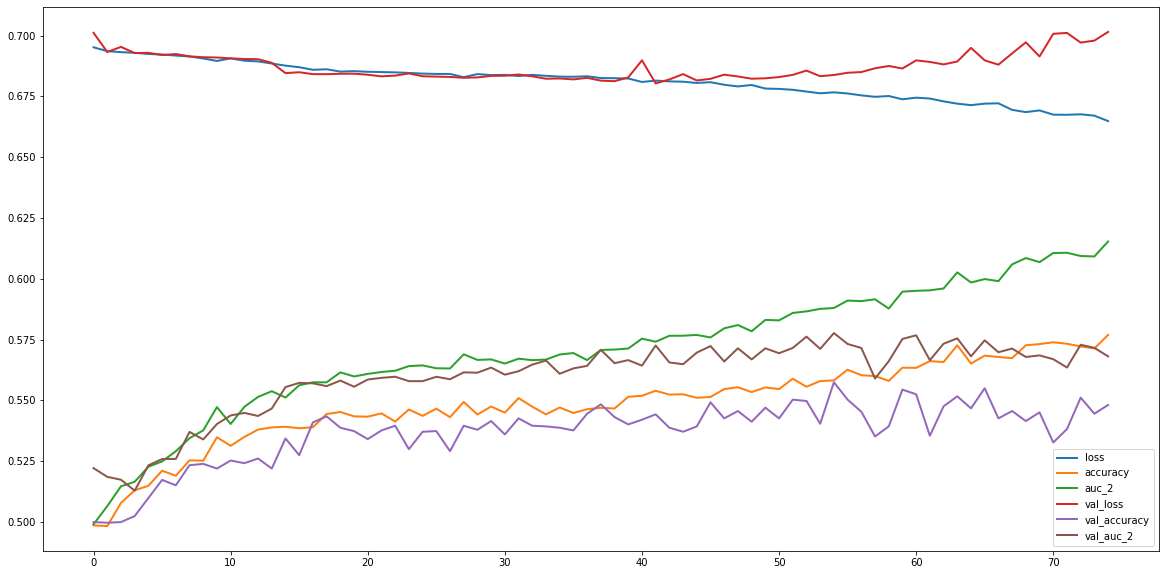

time: 33.1 s (started: 2021-06-10 14:19:05 +00:00)


In [72]:
pd.DataFrame(history.history).plot(lw=2);

In [73]:
Y_train_predicted = network.predict_classes(X)

print(np.array(np.unique(Y, return_counts=True)).T)

a,b = np.unique(Y, return_counts=True)
print("buy hold sell %")
print(b / sum(b))

print(np.array(np.unique(Y_train_predicted, return_counts=True)).T)

a,b = np.unique(Y_train_predicted, return_counts=True)
print("buy hold sell %")
print(b / sum(b))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[0.000e+00 9.089e+03]
 [1.000e+00 9.089e+03]]
buy hold sell %
[0.5 0.5]
[[   0 9318]
 [   1 8860]]
buy hold sell %
[0.51259765 0.48740235]
time: 1.59 s (started: 2021-06-10 14:20:04 +00:00)


In [74]:
Y_train_predicted = network.predict_classes(X)
print(metrics.confusion_matrix(Y, Y_train_predicted))

# Print the precision and recall, among other metrics
print(metrics.classification_report(Y, Y_train_predicted, digits=3))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[5220 3869]
 [4098 4991]]
              precision    recall  f1-score   support

         0.0      0.560     0.574     0.567      9089
         1.0      0.563     0.549     0.556      9089

    accuracy                          0.562     18178
   macro avg      0.562     0.562     0.562     18178
weighted avg      0.562     0.562     0.562     18178

time: 1.27 s (started: 2021-06-10 14:20:11 +00:00)


In [75]:
attempt_number = 2
model_file = "/drive/My Drive/disertation/lstm_attempt_{}__{}_{}_candles_{}_class_{}_window.h5".format(attempt_number, timeframe, candles, classes, window_length)
history_model_file = "/drive/My Drive/disertation/history_lstm_attempt_{}__{}_{}_candles_{}_class_{}_window.h5".format(attempt_number, timeframe, candles, classes, window_length)

if network:
    network.save(model_file)
else:
    from keras.models import load_model
    network = load_model(model_file)

time: 38 ms (started: 2021-06-10 14:20:22 +00:00)


In [41]:
test_df = pd.read_csv("/drive/My Drive/disertation/test_df_{}_{}_candles_{}_class.csv".format(timeframe, candles, classes))
test_df = test_df.set_index("open_time")

time: 128 ms (started: 2021-06-10 13:52:58 +00:00)


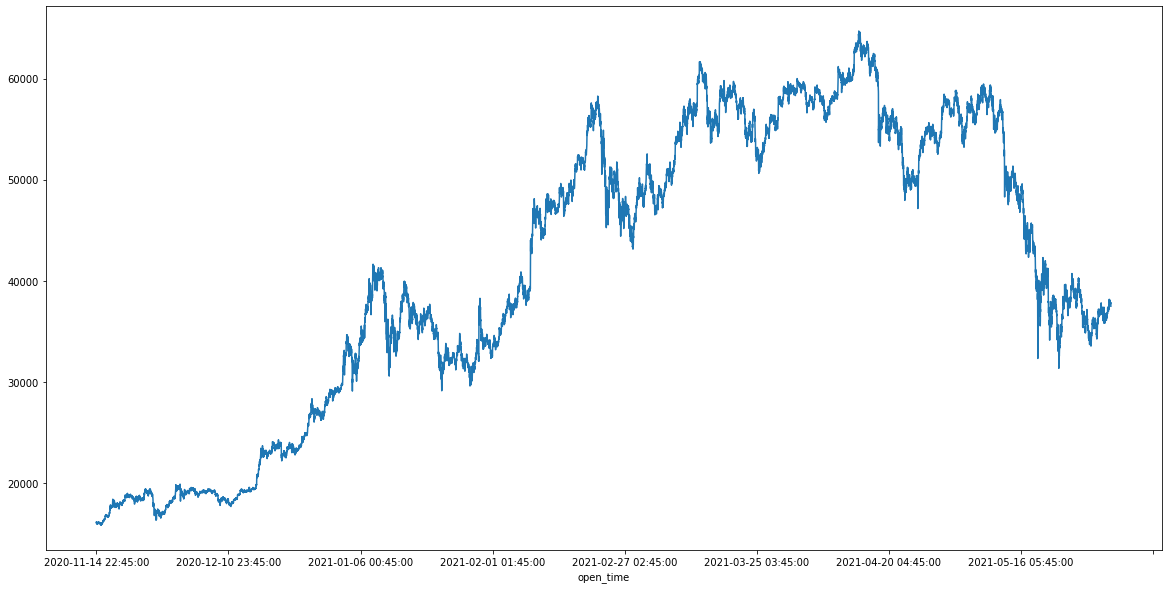

time: 238 ms (started: 2021-06-10 13:52:59 +00:00)


In [42]:
test_df["close"].plot()

In [43]:
test_df.drop(columns=["close"],inplace=True)

data = test_df.to_numpy()
X_test = data[:,:-1]
Y_test = data[:,-1]

X_test, Y_test = extend_dataset_with_window_length(X_test, Y_test)

X_test = scaler.transform(X_test)
X_test = X_test.reshape(X_test.shape[0], n_timesteps, n_features)
X_test.shape, Y_test.shape

((19191, 10, 27), (19191,))

time: 1.44 s (started: 2021-06-10 13:52:59 +00:00)


In [44]:
Y_test_predicted = network.predict_classes(X_test)

print(np.array(np.unique(Y_test, return_counts=True)).T)
a,b = np.unique(Y_test, return_counts=True)
print("buy hold sell %")
print(b / sum(b))


print(np.array(np.unique(Y_test_predicted, return_counts=True)).T)
a,b = np.unique(Y_test_predicted, return_counts=True)
print("buy hold sell %")
print(b / sum(b))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[0.000e+00 9.670e+03]
 [1.000e+00 9.521e+03]]
buy hold sell %
[0.50388203 0.49611797]
[[    0 13806]
 [    1  5385]]
buy hold sell %
[0.71939972 0.28060028]
time: 1.3 s (started: 2021-06-10 13:53:01 +00:00)


In [45]:
print(metrics.confusion_matrix(Y_test, Y_test_predicted))
print(metrics.classification_report(Y_test, Y_test_predicted, digits=3))

[[7226 2444]
 [6580 2941]]
              precision    recall  f1-score   support

         0.0      0.523     0.747     0.616      9670
         1.0      0.546     0.309     0.395      9521

    accuracy                          0.530     19191
   macro avg      0.535     0.528     0.505     19191
weighted avg      0.535     0.530     0.506     19191

time: 62.8 ms (started: 2021-06-10 13:53:02 +00:00)
